# Character Embeddings

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/nn/02-mlp.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---

**References**: {cite}`makemore2` {cite}`Bengio2003`

## Introduction

In this notebook, we implement a character-level language model that learns 
**character embeddings** following {cite}`Bengio2003`. Recall that our previous 
bigram language model maximizes the likelihood of next characters by counting. 
Here we instead pass embeddings of a character's context to an MLP network to get 
a probability vector of the next character.
Instead of learning a large lookup table for each character sequence, we learn an 
embedding vector for each character which are concatenated to represent a character
sequence. 
This approach leads to better generalization.

## Preliminaries

In [1]:
import torch
import torch.nn.functional as F

import math
import warnings
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from matplotlib_inline import backend_inline

DATASET_DIR = Path("./data").absolute()
TRAIN_RATIO = 1.0
RANDOM_SEED = 0
torch.manual_seed(RANDOM_SEED)

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats('svg')

Same **names dataset** as previous notebook:

In [2]:
names = open(DATASET_DIR / 'names.txt', 'r').read().splitlines()
names = names[:int(TRAIN_RATIO * len(names))]

print(len(names))
names[:10]

32033


['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

```{figure} ../../img/char-dataset.drawio.svg
---
width: 330px
name: char-dataset.drawio
---

Using a **block size** of 3 to sample training examples for the name `'olivia'`. Each row indicates an input-output pair in the training dataset, where the input block is represented by the orange cubes, and the blue block highlights the target character.
```

We define a helper class for sampling input-output pairs from the names dataset. The parameter `block_size` refers to the fixed number of previous characters that the model will use for predicting the next one.

In [3]:
class CharDataset:
    def __init__(self, names: list[str], block_size: int):
        self.names = names
        self.chars = ['.'] + sorted(list(set(''.join(names))))
        self.block_size = block_size
        self.itos = dict(enumerate(self.chars))
        self.stoi = {c: i for i, c in self.itos.items()}

    def decode(self, x):
        return ''.join(self.itos[i] for i in x)

    def encode(self, word):
        return [self.stoi[c] for c in word]

    def build_dataset(self):
        """Creating subsequences -> next character target."""
        xs = []
        ys = []
        for name in self.names:
            context = ['.'] * self.block_size
            for c in name + '.':
                xs.append(self.encode(''.join(context)))
                ys.append(self.stoi[c])
                context = context[1:] + [c]
        
        return torch.tensor(xs), torch.tensor(ys)

Note that we simply encode each character in a block to its corresponding integer.

In [4]:
import pandas as pd

dataset = CharDataset(names, block_size=3)
itos = dataset.itos
stoi = dataset.stoi

xs, ys = dataset.build_dataset()

df = pd.DataFrame({'xs': list(xs.numpy()), 'ys': list(ys.numpy())})
df['seq'] = df['xs'].apply(lambda x: ''.join(itos[c] for c in x))
df['target'] = df['ys'].map(itos)
df.head(12)

,xs,ys,seq,target
0,"[0, 0, 0]",5,...,e
1,"[0, 0, 5]",13,..e,m
2,"[0, 5, 13]",13,.em,m
3,"[5, 13, 13]",1,emm,a
4,"[13, 13, 1]",0,mma,.
5,"[0, 0, 0]",15,...,o
6,"[0, 0, 15]",12,..o,l
7,"[0, 15, 12]",9,.ol,i
8,"[15, 12, 9]",22,oli,v
9,"[12, 9, 22]",9,liv,i


In the experiments, we will stick with `block_size=3` for all our models. Using a larger block size does not make sense since most names have around 6 to 7 characters:

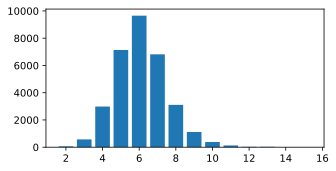

In [5]:
from collections import Counter

count = Counter([len(n) for n in names])
plt.figure(figsize=(5, 2.5))
plt.bar(count.keys(), count.values());

## Character embeddings

Recall that the names we generated using bigrams were pretty bad. Trigrams improve this a bit. But it required a significantly larger matrix. Indeed, the number of rows of the count matrix grows exponentially with context size. There is not enough data to train such a model. Instead, our models will learn an **embedding** for each character, i.e. learnable vector representations of characters, along with the parameters of the MLP network for combining the embedding vectors to calculate probabilities. This model architecture is based on  {cite}`bengio2003a`.

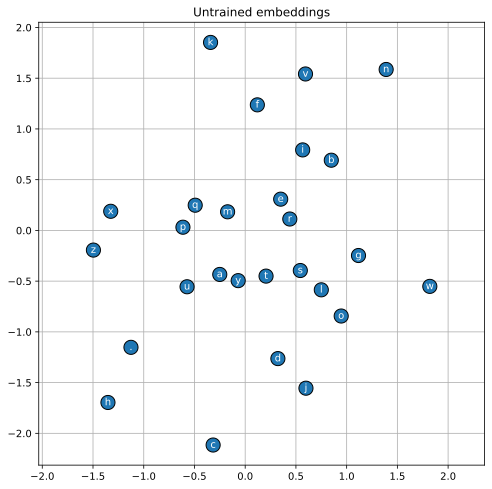

In [6]:
import torch
import string

C = torch.randn(27, 2)
chars = '.' + string.ascii_lowercase

plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200, zorder=3, edgecolors='black')
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), chars[i], ha="center", va="center", color='white')

plt.grid('minor')
plt.axis('equal')
plt.title("Untrained embeddings");

**Figure.** The vector representation of each character is initialized randomly in the *m*-dimensional space. These embeddings will be tuned by the network during training so that similar characters moves closer to each other in the embedding space. Note that unlike the previous approach of learning conditional probabilities using *n*-grams, embeddings can represent character sequences that appear very rarely in the training dataset by using knowledge transfer through character similarity (i.e. $\boldsymbol{\mathsf{w}} \cdot \boldsymbol{\mathsf{x}} \approx \boldsymbol{\mathsf{w}} \cdot \boldsymbol{\mathsf{y}}$ whenever $\boldsymbol{\mathsf{x}} \approx \boldsymbol{\mathsf{y}}$ in the MLP). This should make the model generalize better.

## Network architecture

We will implement the neural network shown in the following figure. 
The first component of the network is an embedding matrix, where each row corresponds to an embedding vector. Then, the embedding vectors are concatenated in the correct order and passed to the two-layer MLP. Here the first layer applies tanh nonlinearity, while the second layer simply performs a linear operation to get the logits. 

Note that during training the weights of the MLP adjusts for character ordering in the input block. And parameters are modified such that the predict probability of the next character is maximized. These include the parameters of the layers as well as the embedding table. To get the unnormalized distribution, we simply apply `.exp()` on the logits. Note that the input and output layer of the network has the same width.

```{figure} ../../img/mlp-char-level.drawio.svg
---
width: 600px
name: mlp-char-level.drawio
---

Schematic diagram of our MLP neural net with embedding and block size of 3. Shown here is the input string `"ner"` passed to the embedding layer. Note that the embeddings are concatenated in the correct order. The resulting concatenation of embeddings are passed to the two-layer MLP with logits.
```

In [7]:
class MLP:
    def __init__(self, embedding_size, width, block_size):
        self.width = width
        self.blk_size = block_size
        self.emb_size = embedding_size
        
        self.C  = torch.randn(27, self.emb_size)
        self.W1 = torch.randn((self.blk_size * self.emb_size, self.width))
        self.b1 = torch.zeros(self.width)
        self.W2 = torch.randn((self.width, 27))
        self.b2 = torch.zeros(27)
        
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        for p in self.parameters:
            p.requires_grad = True

    def __call__(self, xs: list[int]):
        x = self.C[xs].view(-1, self.blk_size * self.emb_size)
        h = torch.tanh(x @ self.W1 + self.b1)
        logits = h @ self.W2 + self.b2
        return logits

    def zero_grad(self):
        for p in self.parameters:
           p.grad = None        

**Remark.** Using `.view` so that the same underlying storage of the tensor is used in the computation.

### Backpropagation

Refer to [this section](00-backprop:appendix-backpropagation-equations-for-mlps) for backpropagating across a linear operation. Here we will be mostly interested with backpropagating through the embedding layer. Observe that the gradient of $\bar{\boldsymbol{{\mathsf{x}}}}$ is just the gradient of $\bar{\boldsymbol{{\mathsf{x}}}}_{\text{cat}}$ reshaped. The embedding operation can be written as $\bar{\boldsymbol{{\mathsf{x}}}}_{btj} = \mathsf{C}_{\boldsymbol{\mathsf{x}}_{bt}j}.$ Hence: 

$$
\begin{aligned}
\frac{\partial\mathcal{L}}{\partial\mathsf{C}_{ij}} 
&= \sum_b \sum_t \sum_k \frac{\partial\mathcal{L}}{\partial\bar{\boldsymbol{{\mathsf{x}}}}_{btk}} \frac{\partial\bar{\boldsymbol{{\mathsf{x}}}}_{btk}}{\partial\mathsf{C}_{ij}} \\
&= \sum_b \sum_t \sum_k \frac{\partial\mathcal{L}}{\partial\bar{\boldsymbol{{\mathsf{x}}}}_{btk}} \boldsymbol{\delta}_{\boldsymbol{\mathsf{x}}_{bt}i} \boldsymbol{\delta}_{jk} \\
&= \sum_b \sum_t \boldsymbol{\delta}_{i\boldsymbol{\mathsf{x}}_{bt}}\frac{\partial\mathcal{L}}{\partial\bar{\boldsymbol{{\mathsf{x}}}}_{btj}}.
\end{aligned}
$$

This looks more complicated than it actually is. The last formula is essentially an instruction on where to add the gradients of $\bar{\boldsymbol{{\mathsf{x}}}}$ for entries that are pulled out of $\mathsf{C}.$ However, note that we are summing also over the batch index since these instances **share** the same embedding weights.

In [8]:
x = xs[:4]

C = torch.randn(27, 10, requires_grad=True)
W = torch.randn(30, 4,  requires_grad=True)
b = torch.randn(4,      requires_grad=True)

x̄     = C[x]       
x̄_cat = x̄.view(x̄.shape[0], -1)
y     = x̄_cat @ W + b

for u in [x̄, x̄_cat, y]:
    u.retain_grad()

loss = (y ** 2).sum(dim=1).mean()
loss.backward()

It follows that the gradient of the embedding matrix is:

In [9]:
δ = F.one_hot(x, num_classes=27).view(-1, 27).float()
dC = δ.T @ x̄.grad.view(-1, 10)

# Checking with autograd
print("maxdiff:", (dC - C.grad).abs().max().item(), "\texact:", torch.all(dC == C.grad).item())

maxdiff: 0.0 	exact: True


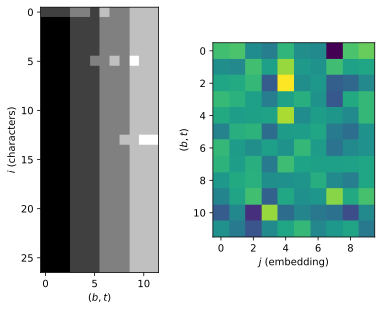

In [10]:
# Three input sequences in a batch (B = 4)
δ = F.one_hot(x, num_classes=27).view(-1, 27).float().T
δ[:, 3: 6] += 1 # add shade
δ[:, 6: 9] += 2
δ[:, 9:12] += 3

fig, ax = plt.subplots(1, 2)
ax[0].imshow(δ.tolist(), interpolation='nearest', cmap='gray')
ax[0].set_xlabel('$(b, t)$')
ax[0].set_ylabel('$i$ (characters)')

ax[1].imshow(x̄.grad.view(-1, 10), interpolation='nearest')
ax[1].set_ylabel('$(b, t)$')
ax[1].set_xlabel('$j$ (embedding)');

**Figure.** [Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta) tensor (left) and gradient tensor (right) from the above equation are visualized. The Kronecker delta tensor indicates all indexes $(b, t)$ where the $i$th character occurs.
All embedding vector gradients $\frac{\partial{\mathcal{L}}}{\partial\bar{\boldsymbol{{\mathsf{x}}}}_{bt:}}$ for the $i$th character are then added over all time steps to get 
$\frac{\partial{\mathcal{L}}}{\partial \mathsf{C}_{i:}}.$ Note that time-dependence can be seen here since the gradients of the embedding for the same character varies over different time steps and contexts. Not just over the batch index.

### Model training

Optimizing `F.cross_entropy` loss which expects logits (i.e. unnormalized class scores). This is equivalent to maximizing next character likelihood.

In [11]:
import torch.nn.functional as F

def optim_step(model, lr):
    for p in model.parameters:
        p.data -= lr * p.grad

def train_model(model, xs, ys, num_steps=100, lr=0.1):
    losses = []
    for k in range(num_steps):
        logits = model(xs)
        loss = F.cross_entropy(logits, target=ys)

        model.zero_grad()
        loss.backward()
        optim_step(model, lr=lr)

        # logging
        losses.append(loss.item())
        if (k % (num_steps // 10) == 0) or (k == num_steps - 1):
            print(f"[{k+1:>03d}/{num_steps}]   loss={loss:.4f}")
    
    return losses


model = MLP(embedding_size=2, width=100, block_size=3)
hist = train_model(model, xs, ys, num_steps=100, lr=0.1)

[001/100]   loss=18.3219
[011/100]   loss=10.3810
[021/100]   loss=7.6844
[031/100]   loss=5.9803
[041/100]   loss=5.0279
[051/100]   loss=4.4630
[061/100]   loss=4.0847
[071/100]   loss=3.8063
[081/100]   loss=3.5909
[091/100]   loss=3.4187
[100/100]   loss=3.2930


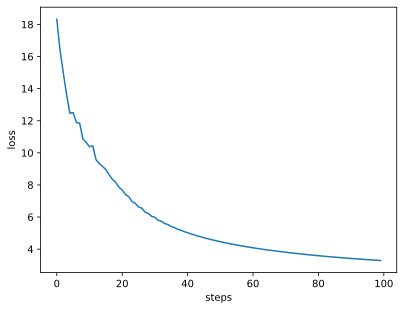

In [12]:
plt.plot(hist)
plt.ylabel('loss')
plt.xlabel('steps');

### Using mini-batches

It is crucial to use **mini-batches** to approximate the gradient. This leads to noisier and more updates, but drastically reduces the resources needed for training. Updating training function:

In [13]:
def train_step(model, x, y, lr=0.1):
    """One step of backward pass and weight update."""
    loss = F.cross_entropy(model(x), y)

    model.zero_grad()
    loss.backward()
    optim_step(model, lr=lr)

    return loss.item()


def train_model(
        model, 
        xs_trn, ys_trn, 
        batch_size, 
        num_steps, 
        lr=0.1, 
        verbose=True
    ):

    losses = []
    for k in range(num_steps):
        
        B = torch.randint(0, xs_trn.shape[0], (batch_size,))
        x, y = xs_trn[B], ys_trn[B]
        loss = train_step(model, x, y, lr)

        # logging
        losses.append(loss)
        if verbose and ((k % (num_steps // batch_size) == 0) or (k == num_steps - 1)):
            print(f"[{k+1:>0{int(len(str(num_steps)))}d}/{num_steps}]   loss: {loss:.4f}")

    return losses


model = MLP(embedding_size=2, width=100, block_size=3)
hist = train_model(model, xs, ys, batch_size=32, num_steps=10000, lr=0.1)

[00001/10000]   loss: 17.6740
[00313/10000]   loss: 3.0656
[00625/10000]   loss: 3.2807
[00937/10000]   loss: 2.4369
[01249/10000]   loss: 2.5706
[01561/10000]   loss: 2.7583
[01873/10000]   loss: 2.2985
[02185/10000]   loss: 2.8942
[02497/10000]   loss: 2.1521
[02809/10000]   loss: 2.2716
[03121/10000]   loss: 2.2840
[03433/10000]   loss: 2.5352
[03745/10000]   loss: 2.6876
[04057/10000]   loss: 2.4422
[04369/10000]   loss: 2.3668
[04681/10000]   loss: 2.5234
[04993/10000]   loss: 2.1590
[05305/10000]   loss: 2.4350
[05617/10000]   loss: 2.3792
[05929/10000]   loss: 2.3431
[06241/10000]   loss: 2.6376
[06553/10000]   loss: 2.4303
[06865/10000]   loss: 2.3931
[07177/10000]   loss: 2.5253
[07489/10000]   loss: 2.3853
[07801/10000]   loss: 2.8113
[08113/10000]   loss: 2.8227
[08425/10000]   loss: 2.5023
[08737/10000]   loss: 2.7382
[09049/10000]   loss: 2.3310
[09361/10000]   loss: 2.4954
[09673/10000]   loss: 2.3664
[09985/10000]   loss: 2.8262
[10000/10000]   loss: 2.8599


Noisier updates:

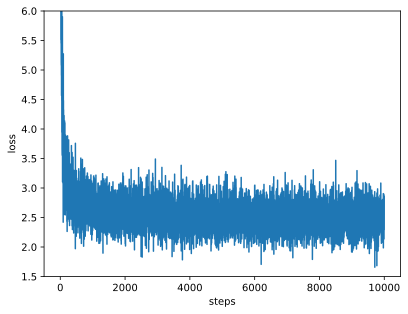

In [14]:
plt.plot(torch.tensor(hist))
plt.xlabel("steps")
plt.ylim(1.5, 6)
plt.ylabel("loss");

## Hyperparameter tuning

To clean up our experimentation code, let us create a trainer class that collects all objects that will be used during training, and also make the training code more readable. For example, this allows us to simply call `trainer.run(n)` to run training with `n` steps. Note that also implement an additional new `lr_finder` method which we will discuss shortly.

In [15]:
class Engine:
    def __init__(self,
            x_train, y_train,
            x_valid, y_valid,
            batch_size=32
        ):
        
        self.x_train = x_train
        self.y_train = y_train
        self.x_valid = x_valid
        self.y_valid = y_valid
        self.batch_size = batch_size


    def run(self, model, num_steps, *, lr=0.1, verbose=True, lr_find=False, **kwargs):
        """Run training with given no. of optim steps."""

        if lr_find:
            lr0 = self.lr_finder(model, **kwargs)
            print(f"Setting learning rate to {lr0:.2e}")
            lr = lr0

        self._lr_counter = 0
        self._best_valid_loss = float("inf")
        loss_train = {}
        loss_valid = {}

        for k in range(num_steps):
            x, y = self.sample_batch()
            loss = self.train_step(model, x, y, lr=lr)
            loss_train[k] = loss
            
            if (k % (num_steps // self.batch_size) == 0) or (k == num_steps - 1):
                loss_val = self.evaluate(model)
                loss_valid[k] = loss_val
                lr = self.lr_step(lr, loss_val, verbose)
                if verbose:
                    print(f"[{k+1:>0{int(len(str(num_steps)))}d}/{num_steps}]      loss={loss:<8.4f}    loss_val={loss_val:.4f}")

        return {
            "loss_train": loss_train,
            "loss_valid": loss_valid
        }


    def lr_finder(self, model, lre_min=-3, lre_max=0, plot=False, color='C0'):
        """Finding a good base learning rate for training."""

        # Training loss at each step
        num_steps = 1000
        lre = torch.linspace(lre_min, lre_max, num_steps)
        lrs = 10 ** lre
        
        losses = []
        for k in range(num_steps):
            x, y = self.sample_batch()
            loss = self.train_step(model, x, y, lr=lrs[k])
            losses.append(loss)

        # Moving average of previous losses
        w = num_steps // 20    # i.e. 1/2 (num_steps // 10)
        loss_ma = []
        for i in range(w, num_steps - w):
            loss_ma.append((lre[i].item(), sum(losses[i-w: i+w]) / (2 * w)))

        # Minimum of MA curve as best learning rate
        i_min = np.argmin([y for _, y in loss_ma])
        assert w < i_min < (num_steps - w) - 1

        # Shift to left (min may be too aggressive)
        best_lre = lre[i_min - w]
        best_lr = 10 ** best_lre

        # Plotting
        if plot:
            plt.figure(figsize=(5, 2.5))
            plt.plot(lre, torch.tensor(losses).numpy(), alpha=0.2, color=color)
            plt.ylabel('loss')
            plt.xlabel('$\log_{10} \lambda$')
            plt.plot([l[0] for l in loss_ma], [l[1] for l in loss_ma], color=color)
            plt.axvline(best_lre, linestyle='dashed', linewidth=1.2, color='black', zorder=-1)
            plt.title(f"$\lambda_0$={best_lr:.3e}")
            
        return best_lr


    def train_step(self, model, x, y, lr):
        """One step of backward pass and weight update."""
        loss = F.cross_entropy(model(x), target=y)
        
        model.zero_grad()        
        loss.backward()
        optim_step(model, lr=lr)
        
        return loss.item()


    @torch.no_grad()
    def evaluate(self, model):
        loss = F.cross_entropy(model(self.x_valid), self.y_valid)
        return loss.item()


    def sample_batch(self):
        B = torch.randint(0, self.x_train.shape[0], (self.batch_size,))     
        x = self.x_train[B]
        y = self.y_train[B]
        return x, y


    def lr_step(self, lr, loss_valid, verbose):
        if loss_valid < self._best_valid_loss:
            self._best_valid_loss = loss_valid
            self._lr_counter = 0
        else:
            self._lr_counter += 1
            if self._lr_counter == 3:
                lr *= 0.1
                self._lr_counter = 0
                if verbose:
                    print(f"Decreasing learning rate to {lr:.2e}")
        return lr

To tune our network, we need to have a validation set:

In [16]:
from sklearn.model_selection import StratifiedKFold

def create_folds(x, y, seed=RANDOM_SEED):
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    folds = torch.zeros(x.shape[0])
    for fold, (train_, valid_) in enumerate(kf.split(x, y)):
        folds[valid_] = fold

    x_train, y_train = x[folds >  1], y[folds >  1]
    x_valid, y_valid = x[folds == 1], y[folds == 1]
    x_test,  y_test  = x[folds == 0], y[folds == 0]

    return x_train, y_train, x_valid, y_valid, x_test, y_test


x_train, y_train, \
x_valid, y_valid, \
x_test,  y_test = create_folds(xs, ys)

### Base learning rate finder

Observe that `lr_finder()` performs training on the model with exponentially increasing learning rate at each optimization step while recording the loss. The returned base learning rate is chosen large enough just before the loss starts destabilizing. On the other hand, during training we work backwards by decreasing the learning rate via a **schedule**. This is a heuristic that works well in practice but is very cheap to compute.

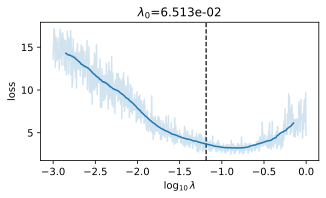

In [17]:
trainer = Engine(
    x_train, y_train,
    x_valid, y_valid,
    batch_size=32
)

model = MLP(embedding_size=2, width=100, block_size=3)
lr0 = trainer.lr_finder(model, lre_min=-3, lre_max=0, plot=True)

Note that we choose a large enough range and number of steps such that we can see a well-defined U-shape in the curve. The `assert` statement allows us to make sure this is satisfied without having to visualize the plot. Also, observe that the minibatches from the training dataset is used as input, since we want to mimic how the learning rate affects training.

### Increasing network width

Training with different network widths:

In [18]:
from tqdm.auto import tqdm

results = {}
for i, h in tqdm(enumerate(range(100, 500, 60))):
    model = MLP(embedding_size=2, width=h, block_size=3)
    results[h] = trainer.run(model, 1000000, verbose=False, lr_find=True)

0it [00:00, ?it/s]

Setting learning rate to 4.51e-02
Setting learning rate to 4.64e-02
Setting learning rate to 4.24e-02
Setting learning rate to 2.37e-02
Setting learning rate to 2.17e-02
Setting learning rate to 2.44e-02
Setting learning rate to 2.34e-02


width=100     valid_loss: 2.2344
width=160     valid_loss: 2.2223
width=220     valid_loss: 2.1973
width=280     valid_loss: 2.2145
width=340     valid_loss: 2.2119
width=400     valid_loss: 2.2236
width=460     valid_loss: 2.2284


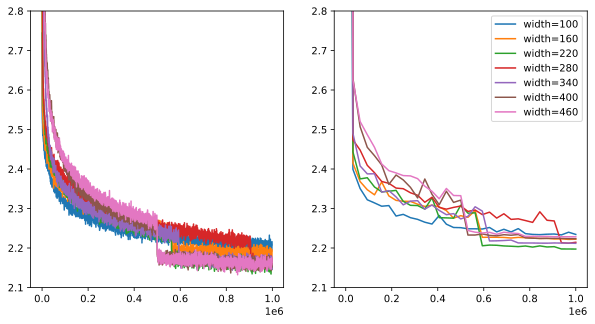

In [19]:
def moving_avg(curve, window):
    curve = np.array(curve)
    n = len(curve)
    ma = [curve[p-window: p+window].mean() for p in range(window, n-window)]
    return ma

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, h in enumerate(results.keys()):
    ax[0].plot(moving_avg(list(results[h]['loss_train'].values()), 500), color=f"C{i}")
    ax[1].plot(results[h]['loss_valid'].keys(), results[h]['loss_valid'].values(), color=f"C{i}", label=f"width={h}")
    print(f"width={h}     valid_loss: {list(results[h]['loss_valid'].values())[-1]:.4f}")


ax[0].set_ylim(2.1, 2.8)
ax[1].set_ylim(2.1, 2.8)
ax[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax[1].legend();

It looks like increasing the network width only results in the network overfitfing the training dataset. Our guess is that embedding size acts like a **bottleneck** to network capacity. We investigate this next.

### Learned embeddings

In this section we will look at embeddings of chacters in two-dimensional space. Recall from the network structure that, vectors with similar embeddings have similar roles in predicting the next character. 

In [20]:
model = MLP(embedding_size=2, width=100, block_size=3)
trainer.run(model, 200000, verbose=True, lr_find=True);

Setting learning rate to 5.56e-02
[000001/200000]      loss=4.9566      loss_val=5.9796
[006251/200000]      loss=2.4797      loss_val=2.4752
[012501/200000]      loss=2.2759      loss_val=2.4267
[018751/200000]      loss=2.5805      loss_val=2.3979
[025001/200000]      loss=2.7624      loss_val=2.4026
[031251/200000]      loss=2.0532      loss_val=2.3838
[037501/200000]      loss=2.1825      loss_val=2.3838
[043751/200000]      loss=2.2278      loss_val=2.3791
[050001/200000]      loss=2.5628      loss_val=2.3687
[056251/200000]      loss=2.4189      loss_val=2.3618
[062501/200000]      loss=2.4015      loss_val=2.3486
[068751/200000]      loss=2.3800      loss_val=2.3430
[075001/200000]      loss=2.3621      loss_val=2.3287
[081251/200000]      loss=2.2667      loss_val=2.3397
[087501/200000]      loss=2.6520      loss_val=2.3299
[093751/200000]      loss=2.0231      loss_val=2.3267
[100001/200000]      loss=2.4214      loss_val=2.3292
[106251/200000]      loss=2.3808      loss_val=2

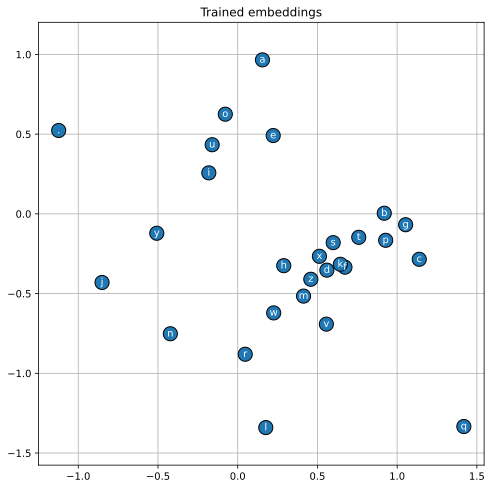

In [21]:
plt.figure(figsize=(8, 8))
plt.scatter(model.C[:, 0].data, model.C[:, 1].data, s=200, edgecolors='black', zorder=3)
for i in range(27):
    plt.text(model.C[i, 0].item(), model.C[i, 1].item(), itos[i], ha="center", va="center", color='white')

plt.grid('minor')
plt.axis('equal')
plt.title("Trained embeddings");

Observe that the vowels are clustered together with `y`. And there are vectors such as `.` and `q` that are isolated from other vectors. We can say that the network has learned these characters. On the other hand, the other consonants being clustered too tightly indicates that the network is not able to understand the subtle differences with these characters, hence just grouping them together.

It seems like it will be difficult improve this with further training or improvements to the network hyparameters. For example, we saw that increasing network width immediately resulted in overfitting. In the next section, we will increase the number of dimensions of the embedding space and see whether this improves performance.

### Increasing the embedding dimension

Based on our previous observations, we consider increasing embedding size to 10. To account for the increase in the number of input neurons, we increase the width of the MLP.

In [22]:
model = MLP(embedding_size=10, width=200, block_size=3)
hist = trainer.run(model, 200000, verbose=True, lr_find=True, lre_min=-3, lre_max=0.4);

Setting learning rate to 7.39e-02
[000001/200000]      loss=18.2881     loss_val=21.3021
[006251/200000]      loss=3.0195      loss_val=2.7810
[012501/200000]      loss=2.7618      loss_val=2.5260
[018751/200000]      loss=2.4315      loss_val=2.4524
[025001/200000]      loss=2.2390      loss_val=2.3883
[031251/200000]      loss=2.0985      loss_val=2.3884
[037501/200000]      loss=2.3246      loss_val=2.3678
[043751/200000]      loss=2.3874      loss_val=2.3692
[050001/200000]      loss=2.4721      loss_val=2.3455
[056251/200000]      loss=2.4898      loss_val=2.3249
[062501/200000]      loss=1.8218      loss_val=2.3147
[068751/200000]      loss=2.2539      loss_val=2.3390
[075001/200000]      loss=2.0279      loss_val=2.2961
[081251/200000]      loss=2.4023      loss_val=2.3288
[087501/200000]      loss=2.1016      loss_val=2.3296
Decreasing learning rate to 7.39e-03
[093751/200000]      loss=2.7141      loss_val=2.3213
[100001/200000]      loss=1.9761      loss_val=2.2158
[106251/20

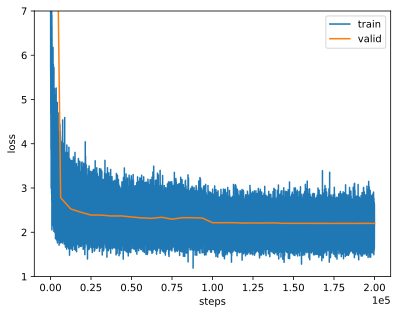

In [23]:
plt.plot(hist['loss_train'].keys(), torch.tensor(list(hist['loss_train'].values())), label='train')
plt.plot(hist['loss_valid'].keys(), torch.tensor(list(hist['loss_valid'].values())), label='valid')

plt.legend()
plt.ylim(1.0, 7)
plt.xlabel("steps")
plt.ylabel("loss")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0));

A larger embedding dimension gets us pretty quickly to a loss below what larger width models obtain with much more training steps.

In [24]:
print(f"loss (valid): {trainer.evaluate(model)}")

loss (valid): 2.2004151344299316


## Sampling names

Finally, we look at names generated by the model.

In [25]:
def generate_names(model, block_size, sample_size):
    """Generate names from a Markov process with cond probability table P."""

    names = []
    for _ in range(sample_size):
        out = []
        context = [0] * block_size
        while True:
            p = model(torch.tensor(context)).exp()
            j = torch.multinomial(p, num_samples=1, replacement=True).item()
            if j == 0:
                break
            context = context[1:] + [j]
            out.append(itos[j])
        names.append(''.join(out))
    return names


def name_loss(name, model, block_size):
    nll = 0.0
    context = [0] * block_size
    for c in name + '.':
        p = F.softmax(model(torch.tensor(context))).reshape(-1)[stoi[c]]
        nll += -math.log(p)
        context = context[1:] + [stoi[c]]
    return nll / (len(name) + 1)


sample = generate_names(model, block_size=3, sample_size=12)
name_losses = {n: name_loss(n, model, block_size=3) for n in sample}
for n in sorted(sample, key=lambda n: name_losses[n]):
    print(f"{n:<22} {name_losses[n]:.3f}")

der                    1.770
casha                  1.774
ader                   1.948
gena                   1.978
olyn                   1.983
cavrik                 2.070
ottorrina              2.123
nobhaedyn              2.268
este                   2.306
jaib                   2.331
tis                    2.349
elaa                   2.615


Nice! This is a huge improvement from our previous notebook.